### **Imports**

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### **Getting the Data**

In [102]:
from data import get_and_preprocess_data
from binance import Client
from secret import KEY, SECRET
from datetime import datetime

data = get_and_preprocess_data(binance_client=Client(KEY, SECRET), 
                                start='2023-01-01',
                                end=datetime.today().strftime('%Y-%m-%d'),
                                symbol='BTCUSDT', 
                                interval=Client.KLINE_INTERVAL_1DAY, 
                                save=True, 
                                dir='data')
data

File already exists.
Timeframe ok. 
Returning already existing file.


,Timestamp,Open,High,Low,Close,Volume
0,2023-01-01,16541.77,16628.00,16499.01,16616.75,96925.41374
1,2023-01-02,16617.17,16799.23,16548.70,16672.87,121888.57191
2,2023-01-03,16672.78,16778.40,16605.28,16675.18,159541.53733
3,2023-01-04,16675.65,16991.87,16652.66,16850.36,220362.18862
4,2023-01-05,16850.36,16879.82,16753.00,16831.85,163473.56641
...,...,...,...,...,...,...
284,2023-10-12,26875.52,26947.04,26555.00,26759.63,23428.64112
285,2023-10-13,26759.63,27130.00,26685.00,26862.00,24115.76499
286,2023-10-14,26862.00,26989.58,26789.00,26852.48,10417.25576
287,2023-10-15,26852.48,27293.33,26808.25,27154.15,15274.69170


### **Initializing TradingEnvironment**

In [103]:
import environment
from environment import TradingEnvironment
from environment import PositionType

import importlib
importlib.reload(environment)

env = TradingEnvironment(data=data,
                         initial_balance=500000,
                         transaction_fee=10)

### **TradingEnvironment Testing Loop**

In [104]:
np.random.seed(42)

balances = np.array([])
portfolios = np.array([])
positions = np.array([])

i=0
while True:
    action = np.random.choice([-1, 0, 1], p=[0.1, 0.80, 0.1])
    volume = np.random.choice(range(6))+1

    # TODO: What should be returned: balance or account value?
    game_over, balance, position = env.step(action, volume)
    
    if position.name != PositionType.HOLD.name:
        print(f"Date: {data['Timestamp'].iloc[i]}\n")

    balances = np.append(balances, balance)
    portfolios = np.append(portfolios, env.portfolio_value)
    positions = np.append(positions, position)

    if game_over:
        break

    i += 1

profit = balances[-1] - env.initial_balance
perc_profit = (profit/env.initial_balance) * 100
print(f'Profit: {profit :.2f}, {perc_profit :.2f}%')

Opened new SHORT position:
Volume: 2
Purchase Price: 16950.31
Cost: 33900.62
Date: 2023-01-07

Bought more SHORT position:
Additional Volume: 4
Updated Purchase Price: 18936.77666666667
Cost: 79720.04
Date: 2023-01-14

Bought more SHORT position:
Additional Volume: 6
Updated Purchase Price: 19904.883333333335
Cost: 125237.94
Date: 2023-01-16

Sold 12 shares of SHORT position for 22666.0.
Total Transaction Profit: -11044.466666666654
Date: 2023-01-21

Sold 8 shares of SHORT position for 23009.65.
Total Transaction Profit: -12419.066666666666
Date: 2023-01-27

Sold 5 shares of SHORT position for 23327.66.
Total Transaction Profit: -13691.10666666666
Position closed
Opened new LONG position:
Volume: 1
Purchase Price: 23327.66
Cost: 23327.66
Date: 2023-02-05

Bought more LONG position:
Additional Volume: 4
Updated Purchase Price: 23259.468
Cost: 92969.68
Date: 2023-02-08

Sold 5 shares of LONG position for 21625.19.
Total Transaction Profit: -1634.2779999999998
Date: 2023-02-11

Sold 4 sha

### **Visualization**

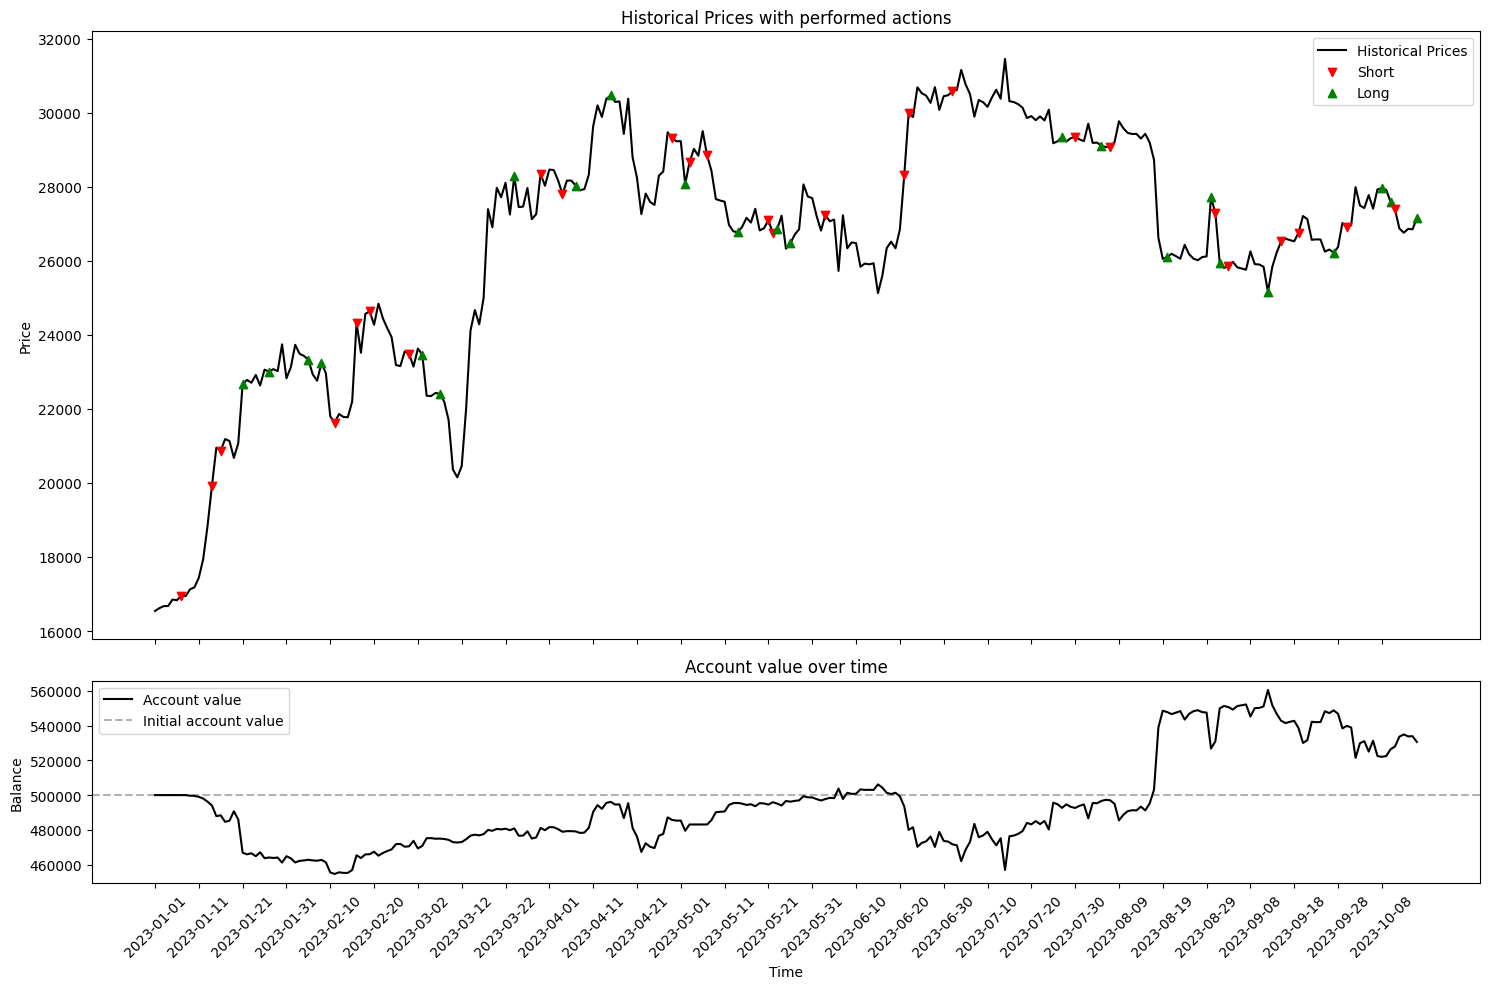

In [105]:
from environment import PositionType

# Initialize a figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# First subplot
# Plot the historical prices
ax1.plot(data['Timestamp'], data['Open'], label='Historical Prices', color='black', zorder=1)

# Counter to inclued only 1 value in legend
long_positions = 0
short_positions = 0

# Add markers for buy and sell transactions
for i, position in enumerate(positions):
    if position == PositionType.LONG:
        long_positions += 1
        color, marker, label, add_legend = 'green', '^', 'Long', long_positions == 1
    elif position == PositionType.SHORT:
        short_positions += 1
        color, marker, label, add_legend = 'red', 'v', 'Short', short_positions == 1
    else:
        continue  # Skip if position is not Long or Short

    ax1.scatter(data['Timestamp'][i], 
                data['Open'][i], 
                color=color, 
                marker=marker, 
                label=label if add_legend==True else '', 
                clip_on=False, 
                zorder=2)

# Set labels and title
ax1.set_title('Historical Prices with performed actions')
ax1.set_ylabel('Price')
ax1.legend(loc='best')

# Second subplot
# Plot the balance value on the second subplot
ax2.plot(data['Timestamp'], (balances+portfolios), color='black', label='Account value')

# Horizontal line for balance
ax2.axhline(y=env.initial_balance, color='black', linestyle='--', alpha=0.3, label='Initial account value')

# Set labels and title for the second subplot
ax2.set_title('Account value over time')
ax2.set_ylabel('Balance')
ax2.set_xlabel('Time')
ax2.legend(loc='best')

# Rotate x-axis labels and display every 10th label
for label in ax2.get_xticklabels():
    label.set_rotation(45)
ax2.set_xticks(ax2.get_xticks()[::10])

plt.tight_layout() 

plt.show()